In [8]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 15 22:37:00 2016

@author: Mohammed qaraad
"""

import random
import numpy
import math
import time


class iPSOeL:
    def __init__(self, objf, lb, ub, dim, PopSize, iters):
        self.objf = objf
        self.lb = lb
        self.ub = ub
        self.dim = dim
        self.PopSize = PopSize
        self.iters = iters

        self.Vmax = 6
        self.wMax = 0.9
        self.wMin = 0.2
        self.c1 = 2
        self.c2 = 2

        self.s = {
            'startTime': None,
            'endTime': None,
            'executionTime': None,
            'convergence': None,
            'optimizer': "IPSOL",
            'objfname': self.objf.__name__,
            'BestX': None,
            'gBestScore': float("inf")
        }
        self.initialize()

    def initialize(self):
        if not isinstance(self.lb, list):
            self.lb = [self.lb] * self.dim
        if not isinstance(self.ub, list):
            self.ub = [self.ub] * self.dim

        self.uF = numpy.zeros((self.PopSize))
        self.uCR = numpy.zeros((self.PopSize))
        self.vel = numpy.zeros((self.PopSize, self.dim))

        self.pBestScore = numpy.zeros(self.PopSize)
        self.pBestScore.fill(float("inf"))

        self.pBest = numpy.zeros((self.PopSize, self.dim))
        self.gBest = numpy.zeros(self.dim)

        self.gBestScore = float("inf")
        
        self.Cost = numpy.full(self.PopSize, float("inf")) # record the fitness of all slime mold
        
        self.pos = numpy.zeros((self.PopSize, self.dim))
        for i in range(self.dim):
            self.pos[:, i] = numpy.random.uniform(0, 1, self.PopSize) * (self.ub[i] - self.lb[i]) + self.lb[i]
        
        for i in range(self.PopSize):
            for j in range(self.dim):
                self.pos[i, j] = numpy.clip(self.pos[i, j], self.lb[j], self.ub[j])
            self.Cost[i] = self.objf(self.pos[i, :])
            if self.pBestScore[i] > self.Cost[i]:
                self.pBestScore[i] = self.Cost[i]
                self.pBest[i, :] = self.pos[i, :].copy()

            if self.gBestScore > self.Cost[i]:
                self.gBestScore = self.Cost[i]
                self.gBest = self.pos[i, :].copy()
        
        self.SmellOrder = numpy.sort(self.Cost)
        self.SmellIndex = numpy.argsort(self.Cost)
        self.Worst_Cost = self.SmellOrder[self.PopSize - 1]
        self.Best_Cost = self.SmellOrder[0]
        self.sorted_population = self.pos[self.SmellIndex, :]
        self.Best_X = self.sorted_population[0, :]
        self.Worst_X = self.sorted_population[self.PopSize - 1, :]
        self.Best_Cost2 = self.SmellOrder[1]
        self.Best_X2 = self.sorted_population[1, :]
        self.Best_Cost3 = self.SmellOrder[2]
        self.Best_X3 = self.sorted_population[2, :]
        self.convergence_curve = numpy.zeros(self.iters)

        print('iPSOeL is optimizing  "' + self.objf.__name__ + '"')

        self.timerStart = time.time()
        self.s['startTime'] = time.strftime("%Y-%m-%d-%H-%M-%S")

    def optimize(self):
        for l in range(self.iters):
            LC = 0.7
            CR = numpy.zeros((self.PopSize))
            ro1 = numpy.zeros((self.PopSize))
            ro2 = numpy.zeros((self.PopSize))
            # Rank the population from lowest to highest
            self.SmellOrder = numpy.sort(self.Cost)
            self.SmellIndex = numpy.argsort(self.Cost)
            w = self.wMax - l * ((self.wMax - self.wMin) / self.iters)
            
            for i in range(self.PopSize):
                self.uF[self.SmellIndex[i]] = i / self.PopSize
                self.uCR[self.SmellIndex[i]] = i / self.PopSize
            
            for i in range(self.PopSize):
                rand = random.sample(range(self.PopSize - 1), 2)
                r1 = int(rand[0])
                r2 = int(rand[1])          
                if self.Cost[i] < self.Best_Cost:
                    self.Best_Cost = self.Cost[i]
                    self.Best_X = self.pos[i, :]
                elif self.Cost[i] > self.Best_Cost and self.Cost[i] < self.Best_Cost2:
                    self.Best_Cost2 = self.Cost[i]
                    self.Best_X2 = self.pos[i, :]
                elif self.Cost[i] > self.Best_Cost and self.Cost[i] > self.Best_Cost2 and self.Cost[i] < self.Best_Cost3:
                    self.Best_Cost3 = self.Cost[i]
                    self.Best_X3 = self.pos[i, :]
                # Generate ro1  and  ro2  using equation (13) in paper
                if random.random() < 0.5:
                    ro1[i] = self.uF[r1] + 0.1 * random.random()
                    ro2[i] = self.uF[r2] + 0.1 * random.random()  #Eq(13)
                else:
                    ro1[i] = self.uF[i] + 0.1 * random.random()
                    ro2[i] = self.uF[i] + 0.1 * random.random()   #Eq(13)
                
                for j in range(self.dim):
                    cof1 = random.random()
                    cof2 = random.random()
                    self.vel[i, j] = (
                        w * self.vel[i, j]
                        + self.c1 * cof1 * (self.pBest[i, j] - self.pos[i, j])
                        + self.c2 * cof2 * (self.gBest[j] - self.pos[i, j])
                    )

                    if self.vel[i, j] > self.Vmax:
                        self.vel[i, j] = self.Vmax

                    if self.vel[i, j] < -self.Vmax:
                        self.vel[i, j] = -self.Vmax

                    self.pos[i, j] = self.pos[i, j] + self.vel[i, j]  # Eq(1)
                
                Xnew = numpy.zeros(self.dim)
                jrand = numpy.random.randint(1, self.dim)
                CR[i] = self.uCR[i] + 0.1 * random.random()  #Eq(15)
                Xm = (self.pos[r1, :] + self.pos[r2, :]) / 2  # Eq(16)
                for j in range(self.dim):
                    if random.random() < CR[i] or j == jrand: #Eq(14)
                        Xnew[j] = Xm[j]
                    else:
                        Xnew[j] = self.pos[i, j]
                
                LC = 4 * LC * (1 - LC)
                if random.random() < LC:
                    k = math.floor(self.PopSize * random.random())
                    if random.random() < 0.5:
                        L2 = 1
                    else:
                        L2 = 0
                    Xp = (1 - L2) * self.Best_X2 + L2 * self.pos[k, :]
                    if random.random() < 0.5 * (1 - (l / self.iters)):
                        Xnew = self.Best_X3 + (ro1[i] * (self.Best_X - Xp) + ro2[i] * (self.pos[r1, :] - self.pos[r2, :])) #Eq(17)
                    else:
                        Xnew = self.Best_X + (ro1[i] * (self.Best_X - Xp) + ro2[i] * (self.pos[r1, :] - self.pos[r2, :]))  #Eq(17)
                
                Xnew = numpy.clip(Xnew, self.lb, self.ub)
                Xnew_Cost = self.objf(Xnew)
                if self.Cost[i] > Xnew_Cost:
                    self.Cost[i] = Xnew_Cost
                    self.pos[i, :] = Xnew
                    if self.Cost[i] < self.Best_Cost:
                        self.Best_X = self.pos[i, :]
                        self.Best_Cost = self.Cost[i]
                if self.pBestScore[i] > self.Cost[i]:
                    self.pBestScore[i] = self.Cost[i]
                    self.pBest[i, :] = self.pos[i, :].copy()

                if self.gBestScore > self.Cost[i]:
                    self.gBestScore = self.Cost[i]
                    self.gBest = self.pos[i, :].copy()
            
            self.convergence_curve[l] = self.gBestScore

        self.timerEnd = time.time()
        self.s['endTime'] = time.strftime("%Y-%m-%d-%H-%M-%S")
        self.s['executionTime'] = self.timerEnd - self.timerStart
        self.s['convergence'] = self.convergence_curve
        self.s['optimizer'] = "iPSOeL"
        self.s['BestX'] = self.Best_X 
        self.s['gBestScore']= self.gBestScore
        return  self.s


# Run optimizer once 

iPSOeL is optimizing  "sphere_function"
Best position: [ 0.04257824  0.1131785   0.10147174 -0.11441284  0.14376561  0.13713344
  0.02257613  0.13397472 -0.00499018 -0.00222163 -0.11933578 -0.03664836
  0.07967137  0.00250593 -0.00236445  0.14090096 -0.00109444  0.03573966
  0.05106537  0.02905036 -0.03600904  0.26257832 -0.04425544 -0.05892944
  0.10492823  0.04426657 -0.06747971  0.000393   -0.02374996  0.07244915]
Best fitness: 0.24151000782650137
Execution time: 0.941237211227417 seconds


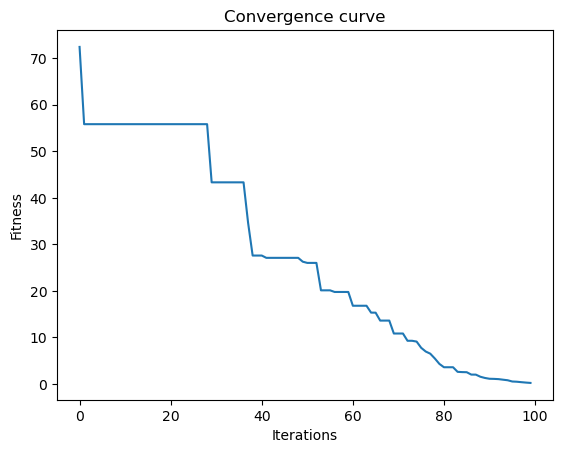

In [10]:
import numpy as np
# Define the Sphere function
def sphere_function(x):
    return np.sum(x**2)

# Create an instance of the PSO class with the Sphere function
optimizer = iPSOeL(objf=sphere_function, lb=-5.12, ub=5.12, dim=30, PopSize=50, iters=100)

# Run the optimization
optimizer.optimize()
# Print the results
print(f"Best position: {optimizer.s['BestX']}")
print(f"Best fitness: {optimizer.s['gBestScore']}")
print(f"Execution time: {optimizer.s['executionTime']} seconds")

# Plotting the convergence curve (if matplotlib is available)
try:
    import matplotlib.pyplot as plt

    plt.plot(optimizer.s['convergence'])
    plt.xlabel('Iterations')
    plt.ylabel('Fitness')
    plt.title('Convergence curve')
    plt.show()
except ImportError:
    print("matplotlib is not installed. Convergence plot will not be displayed.")

# Run optimizer Multiple Runs

iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"
iPSOeL is optimizing  "sphere_function"


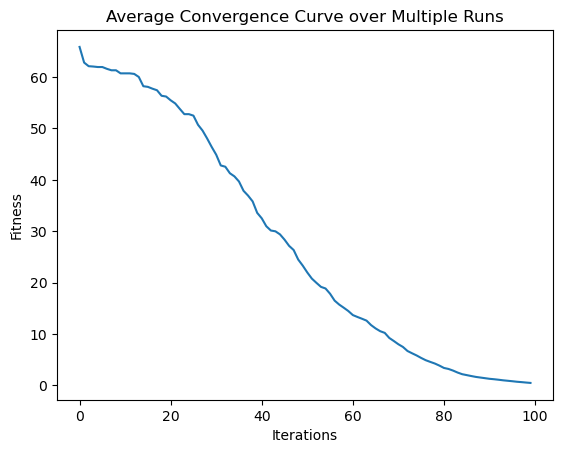

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Sphere function
def sphere_function(x):
    return np.sum(x**2)

# Define the number of runs
num_runs = 30
iterations = 100
pop_size = 50
dim = 30
lb = -5.12
ub = 5.12

# Storage for results
best_positions = []
best_fitnesses = []
execution_times = []
convergence_curves = np.zeros((num_runs, iterations))

# Perform multiple runs
for run in range(num_runs):
    optimizer = iPSOeL(objf=sphere_function, lb=lb, ub=ub, dim=dim, PopSize=pop_size, iters=iterations)
    optimizer.optimize()
    
    best_positions.append(optimizer.s['BestX'])
    best_fitnesses.append(optimizer.s['gBestScore'])
    execution_times.append(optimizer.s['executionTime'])
    convergence_curves[run, :] = optimizer.s['convergence']
    # convergence_curves[run, :] = optimizer.convergence_curve

# Calculate average and standard deviation of the best fitnesses
avg_best_fitness = np.mean(best_fitnesses)
std_best_fitness = np.std(best_fitnesses)

# Calculate average convergence curve
avg_convergence_curve = np.mean(convergence_curves, axis=0)

# Print the results
print(f"Average best fitness over {num_runs} runs: {avg_best_fitness}")
print(f"Standard deviation of best fitness over {num_runs} runs: {std_best_fitness}")
print(f"Average execution time per run: {np.mean(execution_times)} seconds")

# Plotting the average convergence curve
plt.plot(avg_convergence_curve)
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Average Convergence Curve over Multiple Runs')
plt.show()
